## the bottleneck model to tackle 250 products

In [1]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

start_time = time.time()

N_prod = 250        # number of products
Vec_Len = N_prod + 1
Neck_Len = 30       # bottle neck width
EPOCHS = 1000
SAMPLE_AMOUNT = 100000
BATCH_SIZE = 5000
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.0005

# generate latent parameters
transP = MG.GenMarkovM(
    product_num = N_prod,
    gen_func = lambda x : MG.GenTransprob_Sparse(x)
)
lams = np.random.uniform(low = 0, high = 1, size = N_prod)
lams = lams / sum(lams)

# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    
    # generate input vector, which has length vec_len
    # the first element is 0, which should be ignored when treated as an assortment
    assort = AG.GenAssortment_Sparse(N_prod)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)

print("data generated!")
print("total time elapse : ",time.time()-start_time)

train_dataset = TensorDataset(torch.Tensor(INPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]),torch.Tensor(OUTPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]))    
vali_dataset = TensorDataset(torch.Tensor(INPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]),torch.Tensor(OUTPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]))    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
vali_loader = DataLoader(vali_dataset, shuffle=True, batch_size = len(vali_dataset))

model = Models.Bottleneck(Vec_Len, Neck_Len)
optimizer = optim.Adam(model.parameters(), lr = ADAM_LR)
criterion = nn.BCELoss()

training_losses = []
vali_losses = []

for epo in range(1,EPOCHS+1):
    if epo % 50 == 0:
        print("epoch : ",epo)
    for step, (IN, TEST) in enumerate(train_loader):
        
        OUT = model(IN)
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_losses.append(loss.detach().item())
        
    for step, (VALI_IN, VALI_TEST) in enumerate(vali_loader):
        VALI_OUT = model(VALI_IN)
        loss = criterion(VALI_OUT,VALI_TEST)

        vali_losses.append(loss.detach().item())


np.save('EXP2_dump/bottleneck_train_loss', training_losses)
np.save('EXP2_dump/bottleneck_vali_loss', vali_losses)
torch.save(model, "EXP2_dump/bottleneck_model.pth")

data generated!
total time elapse :  133.9357500076294
epoch :  50
epoch :  100
epoch :  150
epoch :  200
epoch :  250
epoch :  300
epoch :  350
epoch :  400
epoch :  450
epoch :  500
epoch :  550
epoch :  600
epoch :  650
epoch :  700
epoch :  750
epoch :  800
epoch :  850
epoch :  900
epoch :  950
epoch :  1000


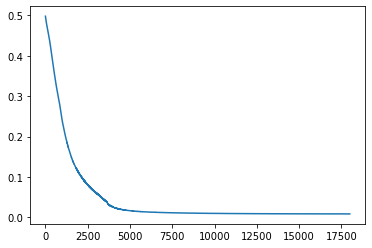

In [2]:
train_loss = np.load('EXP2_dump/bottleneck_train_loss.npy')
plt.plot(train_loss)

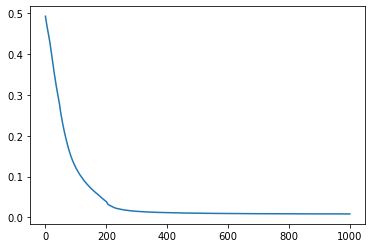

In [3]:
vali_loss = np.load('EXP2_dump/bottleneck_vali_loss.npy')
plt.plot(vali_loss)